In [ ]:
! pip install tweepy
! pip install textblob

# Collect Tweets

In [48]:
import tweepy
import twitter_credentials
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from datetime import datetime, timedelta

In [47]:
class TweetCollector():
	"""
	Class for collecting and processing tweets.
	"""

	def clean_tweet(self, tweet):
		return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

	def collect_tweets(self, hashtag, max_tweets):
		tweets = []
		for tweet in tweepy.Cursor(api.search, q=hashtag, lang='en').items(MAX_TWEETS):
			tweets.append(tweet)

		return tweets

	def get_user_timeline_tweets(self, num_tweets):
		tweets = []
		for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
			tweets.append(tweet)
		return tweets

	def tweets_to_data_frame(self, tweets, to_csv=False):
		df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

		df['id'] = np.array([tweet.id for tweet in tweets])
		df['len'] = np.array([len(tweet.text) for tweet in tweets])
		df['date'] = np.array([tweet.created_at for tweet in tweets])
		df['source'] = np.array([tweet.source for tweet in tweets])
		df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
		df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
		
		if to_csv:
			df.to_csv('tweets_df.csv')

		return df
			

	def analyze_sentiment(self, tweet):
		analysis = TextBlob(tweet)
		
		'''
		if analysis.sentiment.polarity > 0:
			return 1
		elif analysis.sentiment.polarity == 0:
			return 0
		else:
			return -1
		'''

		return analysis.sentiment.polarity

In [3]:
MAX_TWEETS = 10000
since = '2020-01-01'
until = datetime.today().strftime('%Y-%m-%d')

# Authentication
auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
api = tweepy.API(auth)

# Create object
tweet_collector = TweetCollector()

# Collect tweets into dataframe
tweets = tweet_collector.collect_tweets(hashtag="#AAPL since:{} until:{}".format(since, until), max_tweets=MAX_TWEETS)
tweets_df = tweet_collector.tweets_to_data_frame(tweets)

# Clean tweets
tweets_df['tweets'] = pd.DataFrame([tweet_collector.clean_tweet(tweet) for tweet in tweets_df['tweets']])
tweets_df = tweets_df.drop_duplicates(subset=['tweets'])

# Analyze sentiment with TextBlob
tweets_df['sentiment'] = np.array([tweet_collector.analyze_sentiment(tweet) for tweet in tweets_df['tweets']])

#[print(tweet, sent) for tweet, sent in zip(tweets_df['tweets'][:30], tweets_df['sentiment'][:30])]

In [4]:
print('daily sentiment score for {} to {}: '.format(since, until),  tweets_df['sentiment'].sum())

daily sentiment score for 2020-01-01 to 2020-08-10:  100.3658335969586


# Remove Spam

Some tweets may be spam, so we try to remove the sources that generally don't contain quality information about sentiment. 

In [5]:
import matplotlib.pyplot as plt

In [6]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 0 to 870
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   tweets     740 non-null    object        
 1   id         740 non-null    int64         
 2   len        740 non-null    int64         
 3   date       740 non-null    datetime64[ns]
 4   source     740 non-null    object        
 5   likes      740 non-null    int64         
 6   retweets   740 non-null    int64         
 7   sentiment  740 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 52.0+ KB


In [7]:
tweets_df['source'].unique()

array(['Twitter for Android', 'Twitter for iPhone', 'Twitter Web App',
       'dlvr.it', 'MagicPot', 'TweetDeck', 'UTDStockNews',
       'Twitter for iPad', 'Robinheed Upgraded', 'Bot Libre!', 'SpinyApp',
       'Zapier.com', 'TradingView', 'StockTwits Web', 'IFTTT',
       'TQ Alerts', 'Hootsuite Inc.', 'Google',
       'Crypto Overvalued/Undervalued', '', 'Gambiste', 'Instagram',
       'YOUNG APP', 'WordPress.com', 'HFT DeskTop v2.x', 'Hyderabad Bot',
       'Twitter for Mac', 'Apple Retweet Bot', 'TalkMarketsApp',
       'Donald Ndoro 2', 'Buffer', 'MeetEdgar', 'paulcrypto'],
      dtype=object)

### Cumulative Sentiment

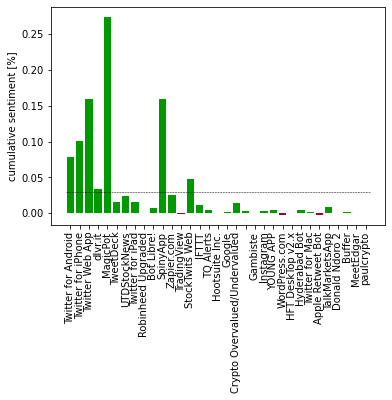

In [8]:
cum_sentiment = []
for source in tweets_df['source'].unique():
    cum_sentiment.append(tweets_df[tweets_df['source'] == source]['sentiment'].sum() / tweets_df['sentiment'].sum())

#tweets_df['cum_sentiment'] = np.cumsum(tweets_df['sentiment'])
#tweets_df['cum_sentiment'].sort_values('c', ascending=False)[['a','b']].plot.bar(stacked=True)

cols = ['#99003d' if x < 0 else '#009900' for x in cum_sentiment]

plt.bar(range(len(cum_sentiment)), cum_sentiment, color=cols)
plt.xticks(range(len(cum_sentiment)), tweets_df['source'].unique(), rotation='vertical')
plt.hlines(np.mean(cum_sentiment), xmin=-0.5, xmax=len(cum_sentiment)-0.5, linestyles='--', linewidth=0.5, label='mean')
plt.ylabel('cumulative sentiment [%]')
plt.show()

We see that some sources have a higher impact on daily sentiment than others.

### Retweets

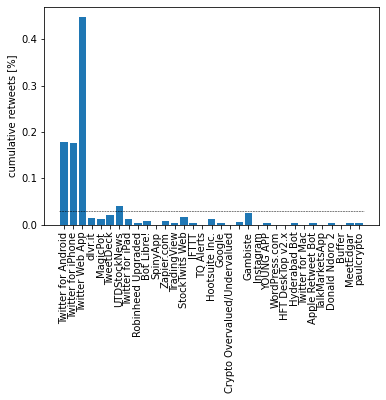

In [9]:
cum_retweets = []
for source in tweets_df['source'].unique():
    cum_retweets.append(tweets_df[tweets_df['source'] == source]['retweets'].sum() / tweets_df['retweets'].sum())

plt.bar(range(len(cum_retweets)), cum_retweets)
plt.xticks(range(len(cum_retweets)), tweets_df['source'].unique(), rotation='vertical')
plt.hlines(np.mean(cum_retweets), xmin=-0.5, xmax=len(cum_retweets)-0.5, linestyles='--', linewidth=0.5, label='mean')
plt.ylabel('cumulative retweets [%]')
plt.show()

We see that some sources are never or rarely retweeted, possibly indicating they have useless content.

### Cum. Sentiment and Retweets

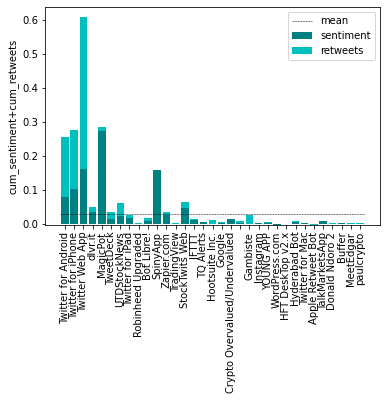

In [10]:
plt.bar(tweets_df['source'].unique(), cum_sentiment, color='teal', label='sentiment')
plt.bar(tweets_df['source'].unique(), cum_retweets, bottom=cum_sentiment, color='c', label='retweets')
plt.hlines(y=np.mean(cum_sentiment+cum_retweets), xmin=-0.5, xmax=len(cum_retweets)-0.5, linestyles='--', linewidth=0.5, label='mean')
plt.ylabel('cum_sentiment+cum_retweets')
plt.xticks(range(len(cum_retweets)), tweets_df['source'].unique(), rotation='vertical')
plt.legend()
plt.show()

We exclude sources with Cum. Sentiment and Retweet under a given threshhold (mean sentiment or retweets), as a source could have a lot of weight on sentiment but no retweets. We could also choose a certain quantile as threshhold.

In [11]:
sent_to_drop = tweets_df['source'].unique()[cum_sentiment < np.mean(cum_sentiment)]
ret_to_drop = tweets_df['source'].unique()[cum_retweets < np.mean(cum_retweets)]
to_drop = list(set(sent_to_drop) | set(ret_to_drop))

In [12]:
tweets_df = tweets_df[~tweets_df['source'].isin(to_drop)]

In [13]:
tweets_df['source'].unique()

array(['Twitter for Android', 'Twitter for iPhone', 'Twitter Web App'],
      dtype=object)

In [14]:
tweets_df.shape

(358, 8)

In [15]:
# Save csv
tweets_df.to_csv('tweets_df.csv', header=True, index=None)

The textblob module for sentiment analysis is not great. Will implement BERT.

# Compute Sentiment Score for Date Range with TextBlob

In [16]:
gb = tweets_df.groupby(tweets_df.date.dt.date)

In [17]:
gb.get_group('2020-08-07')

,tweets,id,len,date,source,likes,retweets,sentiment
110,Someone on aznidentity using the Romance of th...,1291877624436781057,137,2020-08-07 23:23:22,Twitter for iPhone,13,0,0.000000
112,AAPL chart via,1291873103740653576,74,2020-08-07 23:05:24,Twitter Web App,0,0,0.000000
113,what are your picks to click if the heals act ...,1291857107608834065,99,2020-08-07 22:01:50,Twitter for iPhone,0,0,0.000000
115,Welcome to the Pack Wolf Trading Co is here to...,1291850976761131010,140,2020-08-07 21:37:28,Twitter for iPhone,1,1,0.433333
118,SPY CNN Fear amp Greed Index Now Greed 71 ES F...,1291848612239089667,140,2020-08-07 21:28:05,Twitter Web App,5,0,0.000000
119,SPY barchart Fri Unusual Options Activity More...,1291847726360076290,138,2020-08-07 21:24:33,Twitter Web App,4,0,0.350000
120,SPY barchart Fri New 52 week Lows 7 ES F NQ F ...,1291846983351775233,136,2020-08-07 21:21:36,Twitter Web App,3,0,0.136364
122,SPY barchart Fri New 52 weeks highs 175 stocks...,1291846734637924352,132,2020-08-07 21:20:37,Twitter Web App,2,0,0.136364
124,Apple AAPL STOP draining my iPhone11 battery t...,1291846289781596166,110,2020-08-07 21:18:51,Twitter for iPhone,0,1,0.000000
125,SPY barchart Fri Stock Market Momentum ES F NQ...,1291846194893926400,137,2020-08-07 21:18:28,Twitter Web App,5,1,0.000000


In [18]:
daily_sentiment = {}
dates = pd.to_datetime(tweets_df.date.dt.strftime('%Y-%m-%d')).unique()
daily_sentiment['dates'] = dates
daily_sentiment['sentiment'] = [gb.get_group(date).sentiment.sum() for date in dates]

In [19]:
daily_sentiment = pd.DataFrame(daily_sentiment)
daily_sentiment

,dates,sentiment
0,2020-08-09,1.104432
1,2020-08-08,1.187872
2,2020-08-07,4.935360
3,2020-08-06,3.819744
4,2020-08-05,4.657285
5,2020-08-04,7.028066
6,2020-08-03,7.653068
7,2020-08-02,2.008207
8,2020-08-01,1.637229


In [ ]:
! pip install yfinance

In [20]:
import yfinance as yf

In [21]:
dates = pd.to_datetime(tweets_df.date.dt.strftime('%Y-%m-%d').unique())
dates

DatetimeIndex(['2020-08-09', '2020-08-08', '2020-08-07', '2020-08-06',
               '2020-08-05', '2020-08-04', '2020-08-03', '2020-08-02',
               '2020-08-01'],
              dtype='datetime64[ns]', freq=None)

In [22]:
aapl = yf.download('AAPL',dates[-1].strftime('%Y-%m-%d'),dates[0].strftime('%Y-%m-%d'))
aapl.shape

[*********************100%***********************]  1 of 1 completed


(5, 6)

# PLOT

In [23]:
drop_idx = list(set(daily_sentiment.dates[::-1]) - set(aapl.index))
drop_idx

[Timestamp('2020-08-08 00:00:00'),
 Timestamp('2020-08-09 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-08-02 00:00:00')]

In [24]:
daily_sentiment = daily_sentiment[~daily_sentiment.dates.isin(drop_idx)]
daily_sentiment

,dates,sentiment
2,2020-08-07,4.935360
3,2020-08-06,3.819744
4,2020-08-05,4.657285
5,2020-08-04,7.028066
6,2020-08-03,7.653068


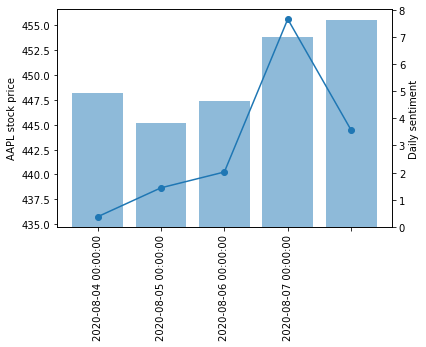

In [25]:
fig, ax1 = plt.subplots()

ax1.plot(range(aapl.shape[0]), aapl['Close'], '-o')
ax1.set_ylabel('AAPL stock price')
ax2 = ax1.twinx()
ax2.bar(range(aapl.shape[0]), daily_sentiment.sentiment, alpha=0.5)
ax2.set_ylabel('Daily sentiment')

ax1.set_xticklabels(aapl.index, rotation='vertical')
plt.show()

# CUMSUM WEEKENDS TO MONDAY [TO DO]

It would be nice to accumulate sentiment on weekends/holidays and add them to the next open trading session.

In [ ]:
aapl['Close']

In [ ]:
daily_sentiment.dates[::-1]

In [ ]:
non_trading_days = list(set(daily_sentiment.dates[::-1]) - set(aapl.index))
non_trading_days.sort()
non_trading_days

In [ ]:
daily_sentiment

In [ ]:
aapl.index

In [ ]:
(daily_sentiment.dates[0] - daily_sentiment.dates[1] == timedelta(days=1))

In [ ]:
[1 if (daily_sentiment.dates[i] - daily_sentiment.dates[i+1] == timedelta(days=1)) else 0 for i in range(daily_sentiment.shape[0]-1)]

In [ ]:
is_consec = [True if (non_trading_days[i+1] - non_trading_days[i] == timedelta(days=1)) else False for i in range(len(non_trading_days)-1)]
is_consec


In [ ]:
daily_sentiment.dates

# MORE DATA

The twitter API only allows to fetch 7 days of tweets for a given hashtag. So we could instead collect data from a user/handle (no date restrictions).

In [49]:
auth = tweepy.OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
api = tweepy.API(auth)

tweet_collector = TweetCollector()

In [50]:
users = ['realDonaldTrump', 'federalreserve', 'CNBC', 'Benzinga', 'Stocktwits', 'BreakoutStocks', 'bespokeinvest',
        'WSJmarkets', 'nytimesbusiness', 'IBDinvestors', 'WSJDealJournal']

In [51]:
df = {}

for user in users:
    
    tweets = api.user_timeline(screen_name=user, count=100)
    tweets_df = tweet_collector.tweets_to_data_frame(tweets)
    tweets_df['tweets'] = pd.DataFrame([tweet_collector.clean_tweet(tweet) for tweet in tweets_df['tweets']])
    tweets_df = tweets_df.drop_duplicates(subset=['tweets'])
    #tweets_df['sentiment'] = np.array([tweet_collector.analyze_sentiment(tweet) for tweet in tweets_df['tweets']])

    df[user] = tweets_df

# Sentiment Prediction

In [53]:
import transformers
import torch
from torch import nn
from transformers import BertModel

In [54]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [7]:
#df = pd.read_csv("tweets_df.csv")

In [55]:
MAX_LEN=160
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
class_names = ['negative', 'neutral', 'positive']
device='cuda'

In [56]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('model_1_2-Copy1.pth'))
model = model.to(device)

In [57]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [67]:
for user in users:

    print('##################')
    print(f'USER: {user}')
    print('##################')
    for text in df[user].tweets[:10]:

        encoded_review = tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)

        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)

        print(f'Review text: {text}')
        print(f'Sentiment : {class_names[prediction]}')
        print('-'*10)

##################
USER: realDonaldTrump
##################
Review text: Thank you to Senator Bill Cassidy of Louisiana for his very smart words on the just signed Executive Orders
Sentiment : positive
----------
Review text: Portland which is out of control should finally after almost 3 months bring in the National Guard The Mayor an
Sentiment : negative
----------
Review text: RINO Ben Sasse who needed my support and endorsement in order to get the Republican nomination for Senate from the
Sentiment : negative
----------
Review text: So now Schumer and Pelosi want to meet to make a deal Amazing how it all works isn t it Where have they been for
Sentiment : neutral
----------
Review text: who just made a fool of himself as he got taken apart by only lasted 11 days in his fa
Sentiment : negative
----------
Review text: This is Fake News by the failing amp bad ratings Never suggested it although based on all of the many
Sentiment : negative
----------
Review text: 
Sentiment : positive


Review text: So far this year U S listed biotechs have raised roughly 9 4 billion in IPOs already beating the 6 5 billion r
Sentiment : positive
----------
Review text: The Dow and S amp P 500 opened the week higher as investors assessed the pace of coronavirus infections fresh federal
Sentiment : neutral
----------
Review text: The stock market s selloff and rebound occurred very rapidly in the first half That was a challenge for long short
Sentiment : negative
----------
Review text: RT Think you can do better than me and our other esteemed columnists Make your pick here
Sentiment : neutral
----------
Review text: RT Twitter investors hit like button on weekend report from wells amp of preliminary TikTok talks St
Sentiment : negative
----------
Review text: RT Economic ties once smoothed strains between the U S and China but businesses now have less power to de escalate tensions
Sentiment : neutral
----------
Review text: Twitter has had preliminary talks with TikTok about a potentia